In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

# Kaggle 2018 Data Science Bowl

All quotes come from this address: https://data.broadinstitute.org/bbbc/BBBC038/

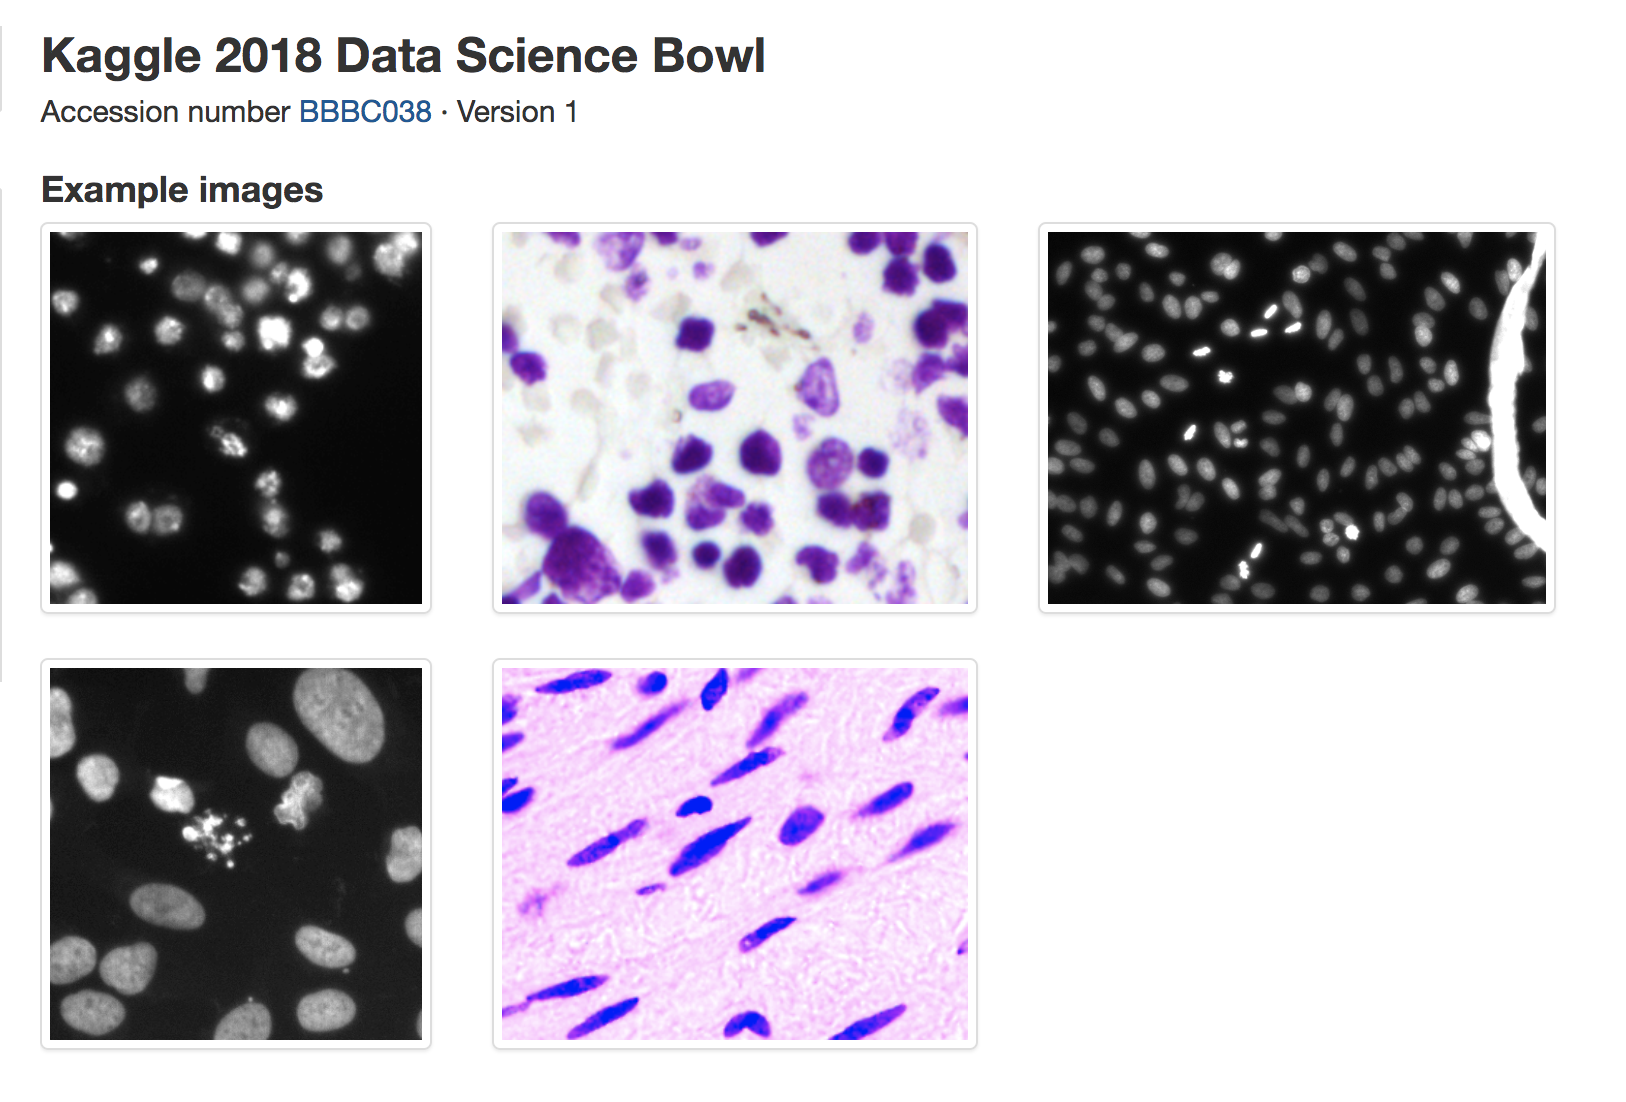

In [2]:
Image('kaggle_info.png')

# MY APPROACH

Goal: create an image processing pipeine that performs nucleus segmentation well on a variety of cell types (different species, different tissues, different stains, tissue/monolayer varied, etc.) automatically without the user needing to provide information about the images/cell types.

My Approach

Given the variety of the images/nuclei (size, background, shape), we can't assume a shape/size of the nucleus so tuning segmentation parameters for a given clustering algorithm/watershed will probably overfit. For a fully-automated pipeline, it will have to adapt to each type of image without supervision. We are going to first identify examples of single cells that are easy to segment (alone on background) and then use the single cell image patches as filters to find that celltype in more complex scenarios (Note: this is essentially how Constrained Spherical Deconvolution with auto-response function in diffusion MRI modeling works). Then we can use the watershed segmentation to set the boundaries between cells, with the cell-specific filtering helping us identify which watershed segmentation regions should be combined.

Steps:

PART I: Segment background from foreground

PART II: Separate individual nuclei

Challenges:
- Watershed oversegmentation; h-minima transform not implemented in skimage so had to adapt from another package's approach
- Given the variety of the images/nuclei (size, background, shape), we can't assume a shape/size of the nucleus so tuning segmentation parameters

# ABSTRACT OF METHODS/RESULTS

## Description of Data

From https://data.broadinstitute.org/bbbc/BBBC038/

"This image data set was created for the Kaggle 2018 Data Science Bowl sponsored by Booz Allen Hamilton with cash prizes. This image set was a testing ground for the application of novel and cutting edge approaches in computer vision and machine learning to the segmentation of the nuclei belonging to cells from a breadth of biological contexts. These images form a diverse collection of biological images collectively containing tens of thousands of nuclei. The variety within the data set reflects the type of images collected by research biologists at universities, bio-techs, and hospitals. The nuclei in the images are derived from a range of organisms including humans, mice, and flies. In addition, nuclei have been treated and imaged in a variety of conditions including fluorescent and histology stains, several magnifications, and varying quality of illumination. Finally, nuclei appear in different contexts and states including cultured mono-layers, tissues, and embryos, and cell division, genotoxic stress, and differentiation."

### Images
"For each image in an image set, for example "stage1_train", there are two folders: 1) A folder named "images" that contains the image of the nuclei, and 2) a folder named "masks", which contains masks that map to every nuclei in the corresponding image."

### Ground Truth
"In addition to the images there is an accompanying collection of annotations. The annotations were originally created by the Broad Imaging Platform. The annotations take the form of a collection of masks for each image of nuclei. Each mask is a PNG file that contains the segmentation of exactly one nuclei in a folder with the same name as the image it refers to. Like the masks, the images of nuclei are also PNG.

The ground truth and annotations were originally created by the Broad Imaging Platform using a combination of GIMP and a web-based annotation tool created internally"

# Import packages, set paths

In [3]:
import pandas as pd
import os
from glob import glob
import numpy as np
import seaborn as sns
import pickle

from IPython.display import Image
from matplotlib.pyplot import imread, imshow, subplot
import matplotlib.pyplot as plt

#OpenCV
import cv2

from skimage import exposure, util
from skimage.color import rgb2gray
from skimage.filters.thresholding import threshold_otsu, threshold_yen

import sklearn.cluster as cluster
from sklearn.cluster import DBSCAN

In [4]:
basepath = '../../data/kaggle/'

trainpath = glob(os.path.join(basepath, '*train*'))[0]
testpath = glob(os.path.join(basepath, '*test*'))[0]

trainsets = glob(trainpath+'/*')
testsets = glob(testpath+'/*')

print('Training Images N=%i' % len(trainsets))
print('Testing Images N=%i' % len(testsets))

Training Images N=670
Testing Images N=65


In [5]:
case1 = trainsets[10]
print(os.listdir(case1))
print('Images in case N=%i' % len(glob(case1+'/images/*')))
print('Masks in case N=%i' % len(glob(case1+'/masks/*')))

['images', 'masks']
Images in case N=1
Masks in case N=150


# Look at the data

To look at all of the masks together, we need to aggregate them

In [6]:
def aggmasks(maskdir):
    imlist = glob(maskdir+'/*.png')
    array = imread(imlist[0])
    agg = np.zeros(array.shape)
    for im in imlist:
        array = imread(im)
        agg += array
        #print(sum(sum(agg)))
    return agg

In [7]:
case1_mask = aggmasks(case1+'/masks')
case1_im = imread(glob(case1+'*/images/*')[0])
print(case1_im.shape)

(520, 696, 4)


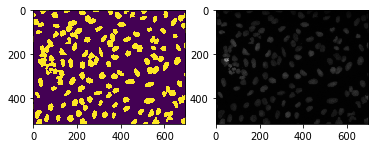

In [8]:
subplot(1,2,1)
imshow(case1_mask)
subplot(1,2,2)
imshow(case1_im)

looks like our images have several channels... let's take a look

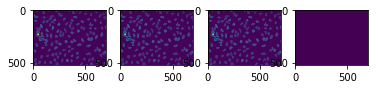

In [9]:
for i in range(case1_im.shape[-1]):
    subplot(1,case1_im.shape[-1],i+1)
    imshow(case1_im[:,:,i])

# PART I: SEGMENT ALL NUCLEI FROM BACKGROUND
This will result in a binary image that indicates nucleus (true) from background (false). This will go into PART II, which separates individual overlapping nuclei from each other.

# Preprocessing

In this case, the first 3 channels are the same because it's grayscale (RBG) and the 4th is the alpha channel, which provides transparency information to render on a background. We aren't interested in this channel so let's get rid of it. We will keep the 3-channels because other images in this dataset are not grayscale so it might be useful for segmentation.

In [10]:
case1_im = np.delete(case1_im,3,2)
assert(case1_im.shape[-1])==3
case1_im.shape

(520, 696, 3)

sanity check: channels should be equal for grayscale images

In [11]:
assert(np.array_equal(case1_im[:,:,0],case1_im[:,:,1]))
assert(np.array_equal(case1_im[:,:,0],case1_im[:,:,2]))

## Since this is a low-contrast image, we should equalize the histogram. 

This shows the channels equalized individually, which might be useful to consider in some of the RGB images

In [12]:
def show_histeq_by_channel(im):
    f = plt.figure(figsize=(10,10))
    lastdim = im.shape[-1]
    newim = im.copy()
    for i in range(lastdim):
        f.add_subplot(4,lastdim,i+1)
        imshow(im[:,:,i]*1)
        f.add_subplot(4,lastdim,i+1+lastdim)
        flat = np.ndarray.flatten(im[:,:,i])
        sns.distplot(flat)
        #normalize histogram
        img_adapteq = exposure.equalize_adapthist(
            im[:,:,i], clip_limit=0.03)
        f.add_subplot(4,lastdim,i+1+lastdim*2)
        imshow(img_adapteq)
        f.add_subplot(4,lastdim,i+1+lastdim*3)
        sns.distplot(np.ndarray.flatten(img_adapteq))
        newim[:,:,i] = img_adapteq
    return newim
    

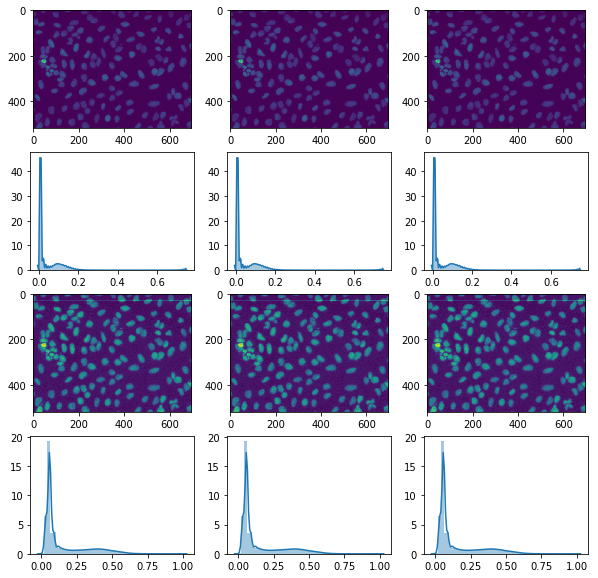

In [13]:
test = show_histeq_by_channel(case1_im)

NOTE: for RGB implementation need to convert to YCbCr, perform histogram equalization on the intensity plane (Y) and convert back to RGB.

In [14]:
def histeq_rgb(rgb_im):
    imgYCR = cv2.cvtColor(rgb_im, cv2.COLOR_RGB2YCR_CB) #check this with an RGB; is is BGR or RGB?
    imgYCR[:,:,0] = exposure.equalize_adapthist(imgYCR[:,:,0], clip_limit=0.03)
    img_adapteq = cv2.cvtColor(imgYCR, cv2.COLOR_YCR_CB2RGB)
    return img_adapteq

In [15]:
case1_histeq = histeq_rgb(case1_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


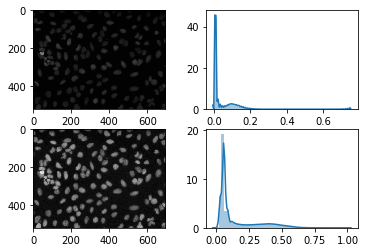

In [16]:
subplot(2,2,1)
imshow(case1_im)
subplot(2,2,2)
sns.distplot(np.ndarray.flatten(case1_im[:,:,0]))
subplot(2,2,3)
imshow(case1_histeq)
subplot(2,2,4)
sns.distplot(np.ndarray.flatten(case1_histeq[:,:,0]))

In [17]:
def reduce_to_one_channel(im):
    return cv2.cvtColor(im, cv2.COLOR_RGB2YCR_CB)[:,:,0]

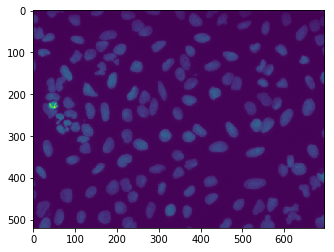

In [18]:
imshow(reduce_to_one_channel(case1_im))

## Now put together the preprocessing

In [19]:
def preproc(image_path, show=False, histeq=False, force_blackbg=True, grayscale=False):
    im = imread(image_path)
    orig = im.copy()
    if im.shape[-1] == 4:
        im = np.delete(im,3,2)
    assert(len(im.shape)==3)
    assert(im.shape[-1])==3
    if force_blackbg:
        nphist = np.histogram(im, bins=10)[0]
        if sum(nphist[:5])<sum(nphist[5:]):
            #print('Flipping white background to black')
            im = util.invert(im)
    if histeq:
        im = histeq_rgb(im)
    if grayscale:
        im = rgb2gray(im)
    if show:
        subplot(2,3,1)
        imshow(orig)
        plt.title('Original')
        subplot(2,3,2)
        imshow(histeq_rgb(im))
        plt.title('Hist Eq')
        subplot(2,3,3)
        imshow(rgb2gray(orig))
        plt.title('Grayscale')
        subplot(2,3,4)
        sns.distplot(np.ndarray.flatten(orig))
        subplot(2,3,5)
        sns.distplot(np.ndarray.flatten(im))
        subplot(2,3,6)
        sns.distplot(np.ndarray.flatten(rgb2gray(orig)))
    return im

Now you can take a look at any of the images by changing the index of trainsets (note: 110 is RGB)

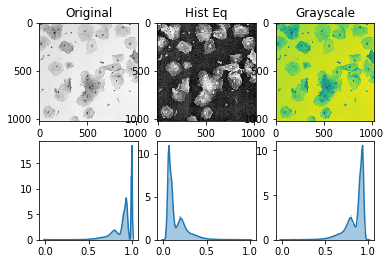

In [20]:
N_test = 100
test = preproc(glob(trainsets[N_test]+'*/images/*')[0], show=True, histeq=False, force_blackbg=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


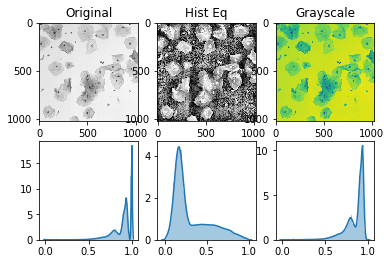

In [21]:
test_histeq = preproc(glob(trainsets[N_test]+'*/images/*')[0], show=True, histeq=True, force_blackbg=True)

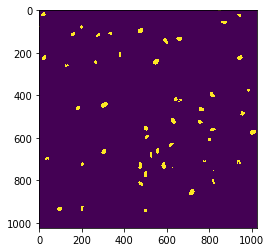

In [22]:
test_mask = aggmasks(trainsets[N_test]+'/masks')
imshow(test_mask)

looking at case 100, we may not want to equalize the histograms if circular objects of a certain contrast are already segmentable

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


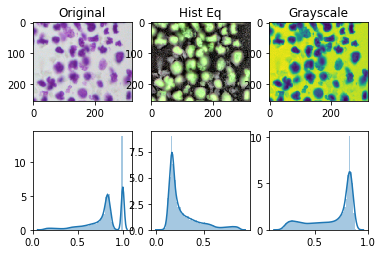

In [23]:
N_test_color = 110
test_color = preproc(glob(trainsets[N_test_color]+'*/images/*')[0], show=True, histeq=False)

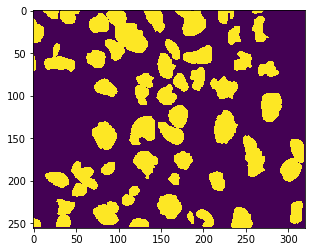

In [24]:
test_color_mask = aggmasks(trainsets[N_test_color]+'/masks')
imshow(test_color_mask)

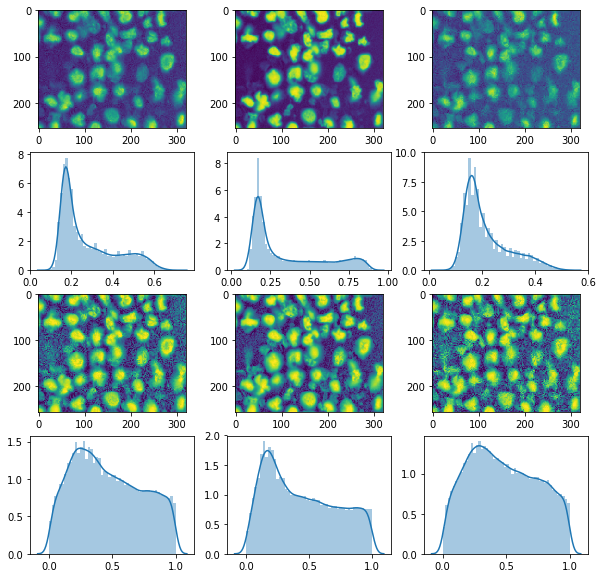

In [25]:
test_color_by_channel = show_histeq_by_channel(test_color)

# Apply a Threshold

After testing equalized vs non-equalized histograms on a few, it looks like we should try non-equalized for now

## Sorensen-dice index/PCVA = percent overlap of masks used as metric

In [26]:
def calc_pcva(mask1,mask2): 
    pcva = 200*sum(sum(np.logical_and(mask1,mask2)))/(sum(sum(mask1))+sum(sum(mask2)))
    return pcva

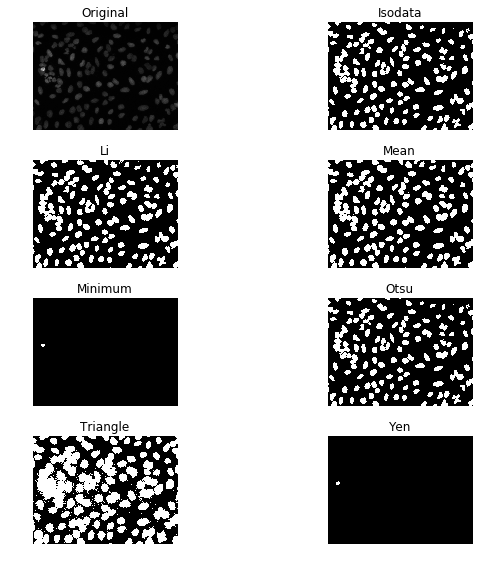

In [27]:
#Plot adapted from skimage example
#CITE: http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html#sphx-glr-auto-examples-segmentation-plot-thresholding-py
from skimage.filters import try_all_threshold

img = rgb2gray(case1_im)

# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [28]:
calc_pcva(rgb2gray(case1_im)>threshold_otsu(rgb2gray(case1_im)), case1_mask)

94.04343329886247

Median otsu seems good for case1... 94% overlap

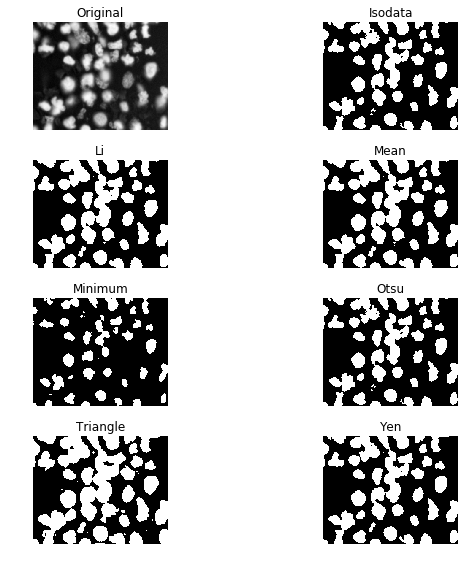

In [29]:
fig, ax = try_all_threshold(rgb2gray(test_color), figsize=(10, 8), verbose=False)
plt.show()

In [30]:
calc_pcva(rgb2gray(test_color)>threshold_otsu(rgb2gray(test_color)), test_color_mask)

87.69990294949154

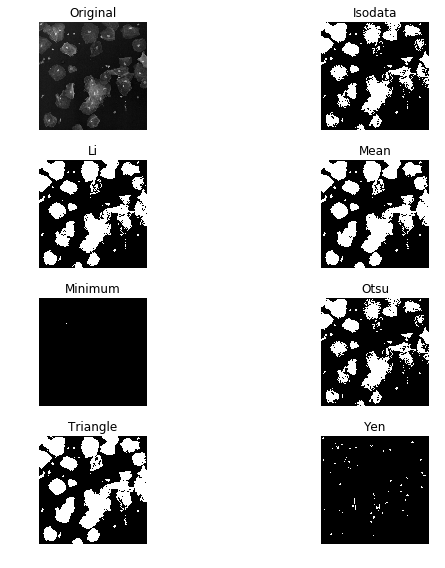

In [31]:
#None of these work on the equalized image... it's picking out the wrong foreground... 
#this type of image needs a different approach... 
#as an untrained human classifier I would need to know it's the small dots
#YEN WORKED ON NON-EQUALIZED IMAGE
fig, ax = try_all_threshold(rgb2gray(test), figsize=(10, 8), verbose=False)
plt.show()

In [32]:
calc_pcva(rgb2gray(test)>threshold_otsu(rgb2gray(test)), test_mask)

10.136917932422765

In [33]:
calc_pcva(rgb2gray(test)>threshold_yen(rgb2gray(test)), test_mask)

60.66732645270748

Future improvement: use texture analysis to identify which segmentations should use Yen

In [34]:
def test_otsu(imsets, thrmethod='otsu'):
    pcva_list = np.zeros(len(imsets))
    bad_list = []
    for i,t in enumerate(imsets):
        #calculate aggregate mask as gold standard
        maskloc = os.path.join(t,'masks')
        wholemask = aggmasks(maskloc)
        #segment background/foreground
        impath = glob(t+'/im*/*.png')[0]
        impreproc = preproc(impath)
        if thrmethod is 'otsu':
            imseg = rgb2gray(impreproc)>threshold_otsu(rgb2gray(impreproc))
        elif thrmethod is 'yen':
            imseg = rgb2gray(impreproc)>threshold_yen(rgb2gray(impreproc))
        pcva = calc_pcva(imseg, wholemask)
        #print(pcva)
        pcva_list[i] = pcva
        if pcva<80:
            bad_list.append(t)
    return pcva_list, bad_list

In [35]:
otsu_pcva, otsu_bad = test_otsu(trainsets, thrmethod='otsu')

In [36]:
yen_pcva, yen_bad = test_otsu(trainsets, thrmethod='yen')

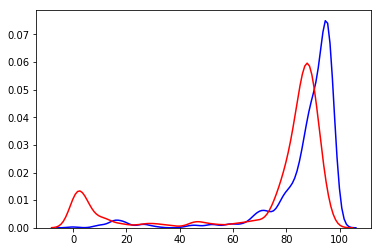

In [37]:
sns.kdeplot(otsu_pcva, c='b')
sns.kdeplot(yen_pcva, c='r')

Looks like otsu (blue) is performing adequately to move on... this should be revisited to figure out how to identify the badly performing cases (perhaps w/texture) and use a different method

## Knobs that matter: 

- Equalize the histogram or don't
- threshold method choice depends on this

NOTE: still using grayscale so throwing out a lot of info

TODO: Optimize the choice of thresholding method on the training set

## Future improvement:
If we knew or could detect the staining of each image we could use color deconvolution and pick the one that represents the nucleus (Example, below)

http://www.cureffi.org/2012/05/13/color-transformations-for-segmenting-complex-images/

http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html

# PART II: Segmentation of Mask

We will assume an idealized segmentation for this portion, so we will use the aggregated masks and in this section try to separate the nuclei. In the end, parts I and II would be combined into a complete platform but for the moment we develop and optimize them independently.

In [38]:
#set colormap for id
cmap = plt.cm.hsv
cmap.set_under(color='black')  

cmap_prism = plt.cm.prism
cmap_prism.set_under(color='black')

## Watershed-based algorithm for segmentation

http://scikit-image.org/docs/stable/auto_examples/segmentation/plot_compact_watershed.html#sphx-glr-auto-examples-segmentation-plot-compact-watershed-py

In [39]:
#Adapted code from skimage example: watershed segmentation
#CITE: http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

#IMPLEMENTATION FROM GALA (NOT IMPLEMENTED IN SKIMAGE)
#CITE: https://gala.readthedocs.io/en/latest/installation.html
#INSTALLATION PROBLEMS SO HAD TO COPY DIRECTLY IN

from scipy.ndimage import grey_dilation, generate_binary_structure

def morphological_reconstruction(marker, mask, connectivity=1):
    """FROM GALA"""
    sel = generate_binary_structure(marker.ndim, connectivity)
    diff = True
    while diff:
        markernew = grey_dilation(marker, footprint=sel)
        markernew = np.minimum(markernew, mask)
        diff = (markernew-marker).max() > 0
        marker = markernew
    return marker

def hminima(a, thresh):
    """FROM GALA"""
    maxval = a.max()
    ainv = maxval-a
    return maxval - morphological_reconstruction(ainv-thresh, ainv)

In [40]:
#Adapted code from skimage example: watershed segmentation and some functions from GALA that weren't implemented
#CITE: http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py
#CITE: CITE: https://gala.readthedocs.io/en/latest/installation.html

def dowatershedseg(image, show=False, hminthresh=2):
    distance = ndi.distance_transform_edt(image)
    origdist = distance.copy()
    #sns.kdeplot(np.ndarray.flatten(distance[distance>0]))
    
    #OVERSEGMENTATION WITHTOUT THIS... SCIKIT IMAGE DOESN'T HAVE H-MINIMA TRANSFORM IMPLEMENTED
    #HMINTHRESH SHOULD BE PRIMARY METRIC FOR TUNING
    distance = util.invert(hminima(util.invert(distance), hminthresh))
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                                labels=image)
    distance = -distance #creates catchement basins
    markers = ndi.label(local_maxi)[0]
    labels = watershed(distance, markers, mask=image)
    if show:
        cmap = plt.cm.hsv
        cmap.set_under(color='black') 
        fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
        ax = axes.ravel()

        ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
        ax[0].set_title('Overlapping objects')
        ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
        ax[1].set_title('Distances')
        ax[2].imshow(local_maxi, cmap=plt.cm.gray, interpolation='nearest')
        ax[2].set_title('Local Maxima')
        ax[3].imshow(labels, cmap=cmap_prism, interpolation='nearest', vmin=0.000001)
        ax[3].set_title('Separated objects')

        for a in ax:
            a.set_axis_off()

        fig.tight_layout()
        plt.show()
    return labels

Let's try the segmentation on the aggregated mask... we expect this to work well

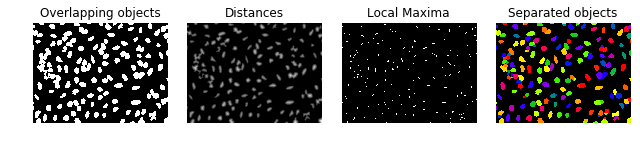

In [41]:
labels = dowatershedseg(case1_mask, show=True)

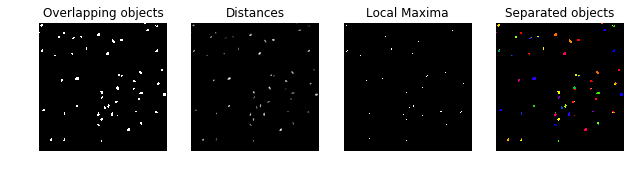

In [42]:
labels_t = dowatershedseg(test_mask, show=True)

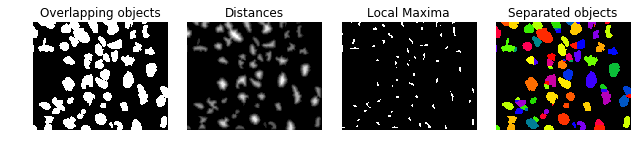

In [43]:
labels_tc = dowatershedseg(test_color_mask, show=True)

We have a problem with splitting of single nuclei

Thought: what if we made a filter out of the lone blobs (largest watershed size)? (assuming at least a few nuclei will be on their own and easy to segment) and used that to help with the splitting problem?

- use another segmentation (kmeans/dbscan etc) to split up blobs
- pick candidate ideal blobs based on histogram (highest watershed peak)
- pick the blobs that are consistent between clustering and watershed
- use those "ideal blobs" as a filter to decide which watersheds to merge

### First let's get rough cluster labels with DBSCAN

In [44]:
#right now ncl = int(labels.max()/4)
def docluster(im, alg='dbscan'):
    coords = np.where(im>0)
    coordarray = np.zeros([coords[0].shape[0],2])
    coordarray[:,0] = coords[0]
    coordarray[:,1] = coords[1]
    
    #later will use something more optimal like DBSCAN but for now kmeans
    if alg is 'kmeans':
        ncl=int(labels.max()/2)
        y_pred = cluster.KMeans(n_clusters=ncl).fit_predict(coordarray)
    elif alg is 'dbscan':
        db = DBSCAN(eps=1, min_samples=1).fit(coordarray)
        y_pred = db.labels_.astype(np.int)
    cluster_im = np.zeros(im.shape)
    for i in range(y_pred.shape[0]):
        x,y = coordarray[i,:]
        cluster_im[int(x),int(y)] = y_pred[i]
    return cluster_im

In [45]:
coords = np.where(case1_mask>0)
coordarray = np.zeros([coords[0].shape[0],2])
coordarray[:,0] = coords[0]
coordarray[:,1] = coords[1]

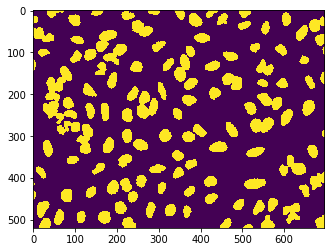

In [46]:
imshow(case1_mask)

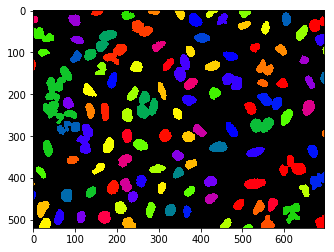

In [47]:
db_im = docluster(case1_mask, alg='dbscan')
imshow(db_im, cmap=cmap_prism, vmin=0.01)

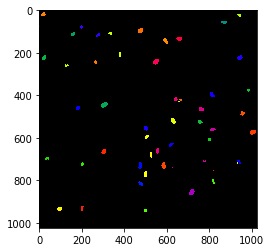

In [48]:
db_im_t = docluster(test_mask, alg='dbscan')
imshow(db_im_t, cmap=cmap_prism, vmin=0.01)

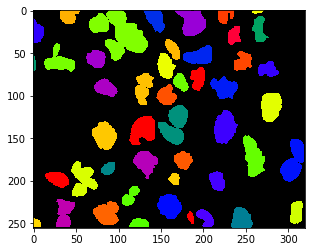

In [49]:
db_im_tc = docluster(test_color_mask, alg='dbscan')
imshow(db_im_tc, cmap=cmap_prism, vmin=0.01)

### Now let's look at the sizes of the blobs

In [50]:
def calc_blobsize(im, nbins):
    watershed_sizes = np.histogram(labels, bins=labels.max())[0]

(0, 4525)

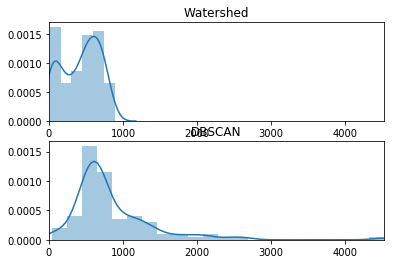

In [51]:
watershed_sizes = np.histogram(labels, bins=labels.max())[0]
db_sizes = np.histogram(db_im, bins=int(labels.max()/2))[0]
xmax = max(watershed_sizes[1:].max(),db_sizes[1:].max())

subplot(2,1,1)
sns.distplot(watershed_sizes[1:]) #first is background
plt.title('Watershed')
plt.xlim(0,xmax)

subplot(2,1,2)
sns.distplot(db_sizes[1:]) #first is background
plt.title('DBSCAN')
plt.xlim(0,xmax)

Hypothesis: the larger watershed and the peak of kmeans are similar when we have a good segmentation for our pipeline

THOUGHT: to compare these, let's assign the pixel value to the size of the blob it belongs to; then we can just compare the images

In [52]:
def getcountim(im, background=0):
    counts_im = np.zeros(im.shape)
    for i in np.unique(im):
        if i==0:
            counts_im[im==i] = background
        else:
            counts_im[im==i] = sum(sum(im==i) )
    return counts_im

Text(0.5,1,'watershed cluster size')

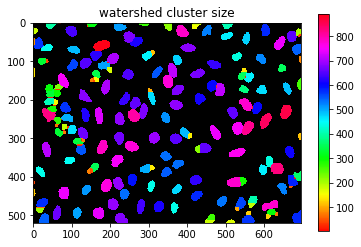

In [53]:
imshow(getcountim(labels), cmap=cmap, vmin=0.001)
plt.colorbar()
plt.title('watershed cluster size')

The largest watershed segmentations are the best segmentations

Text(0.5,1,'DBSCAN cluster size')

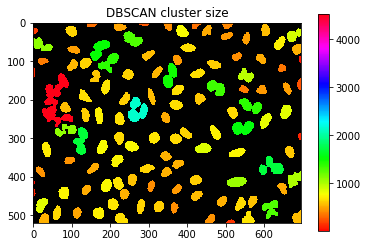

In [54]:
imshow(getcountim(db_im), cmap=cmap, vmin=0.001)
plt.colorbar()
plt.title('DBSCAN cluster size')

The peak of the kmeans histogram (around a cluster size of 500-750) seems to agree pretty well with the loner cells

In [55]:
def compare_segmentations(seg1,seg2,show=False, title1='seg1', title2='seg2'):
    
    counts_seg1 = getcountim(seg1)
    counts_seg2 = getcountim(seg2)
    agreement = np.logical_and(counts_seg1 > 0, counts_seg2 == counts_seg1)
    
    if show:
        fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
        ax = axes.ravel()

        ax[0].imshow(counts_seg1, cmap=cmap, vmin=0.001)
        ax[0].set_title('%s cluster size' % title1)
        ax[1].imshow(counts_seg2, cmap=cmap, vmin=0.001)
        ax[1].set_title('%s cluster size' % title2)
        ax[2].imshow(agreement, cmap=cmap, vmin=0.001)
        ax[2].set_title('Agreement')

        for a in ax:
            a.set_axis_off()

        fig.tight_layout()
        plt.show()
    return agreement

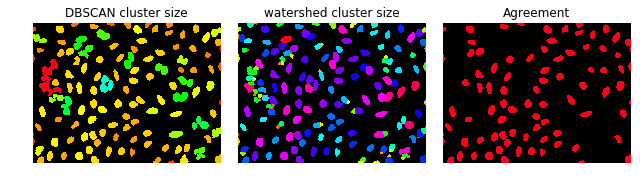

In [56]:
case1_agree = compare_segmentations(db_im, labels, show=True, title1='DBSCAN',title2='watershed')

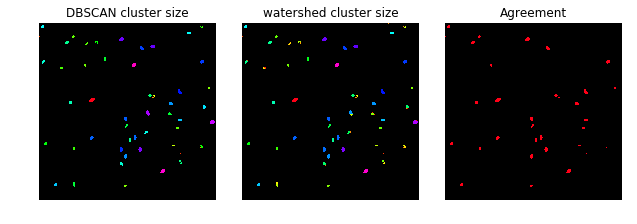

In [57]:
test_agree = compare_segmentations(db_im_t, labels_t, show=True, title1='DBSCAN',title2='watershed')

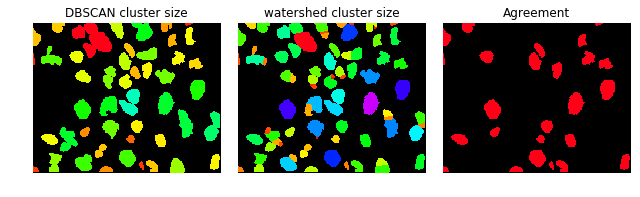

In [58]:
test_color_agree = compare_segmentations(db_im_tc, labels_tc, show=True, title1='DBSCAN',title2='watershed')

It looks like this worked pretty well. 

We don't want it if it's touching an edge, so let's make sure we only take ones with a good bounding box

Future improvements:
- use dbscan instead of kmeans to do the simple clustering  Update: DONE!!
    - http://scikit-learn.org/0.15/auto_examples/cluster/plot_cluster_comparison.html
    - http://qingkaikong.blogspot.com/2016/08/clustering-with-dbscan.html
- need to test this on cells that have weirder shapes
- do all of the cells have at least a few that are easy to segment?
- maybe detect the type of cell instead and have a bank of filters... e.g. inertia ratio
    - https://www.learnopencv.com/blob-detection-using-opencv-python-c/

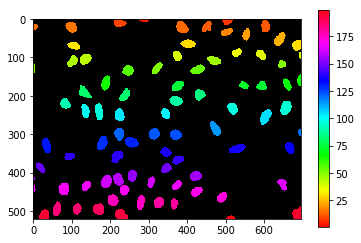

In [59]:
agreement_labels = labels*case1_agree
imshow(agreement_labels, cmap=cmap,vmin=0.0000001)
plt.colorbar()

In [60]:
#size_boundbox is the number of extra pixels we want beyond the edge of the mask
def make_patches(label_im, raw_im, boundbox=2, show=False):
    rmax, cmax = label_im.shape
    label_im_nobg = label_im[label_im>0]
    unique_labels = np.unique(label_im_nobg)
    patches = []
    for p in unique_labels:
        patchbin = label_im==p
        coordsr, coordsc = np.where(patchbin)
        #Check that the blob isn't at the edge so we can exclude it
        prmax = max(coordsr)
        pcmax = max(coordsc)
        prmin = min(coordsr)
        pcmin = min(coordsc)
        if prmax >= rmax-boundbox or pcmax >= cmax-boundbox or prmin <= boundbox or pcmin <= boundbox:
            continue
        else:
            patch = raw_im[prmin-boundbox:prmax+boundbox,pcmin-boundbox:pcmax+boundbox]
            patches.append(patch)
    if show:
        for i in range(len(patches)):
            subplot(1,len(patches),i+1)
            imshow(patches[i])
            plt.axis('off')
        fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
        ax = axes.ravel()

        ax[0].imshow(patches[0], cmap=plt.cm.gray)
        ax[1].imshow(patches[1], cmap=plt.cm.gray)
        ax[2].imshow(patches[2], cmap=plt.cm.gray)

        for a in ax:
            a.set_axis_off()

        fig.tight_layout()
        plt.show()
    return patches

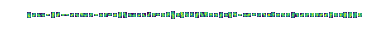

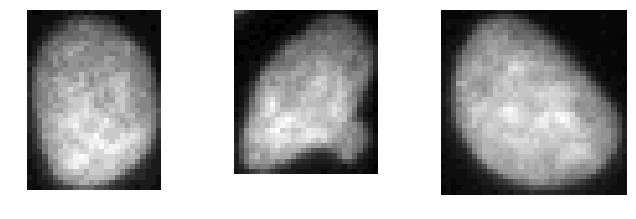

In [61]:
mypatches = make_patches(agreement_labels, rgb2gray(case1_im), show=True)

Future improvement: pick a few filters if they aren't similar enough for cell types with odd shapes/orientations

In [62]:
#Adapted from skimage example
#CITE: http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_template.html#sphx-glr-auto-examples-features-detection-plot-template-py

import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import match_template

def dotempmatch(image, patch, show=False):
    result = match_template(image, patch, pad_input=True)
    ij = np.unravel_index(np.argmax(result), result.shape)
    x, y = ij[::-1]

    if show:
        fig = plt.figure(figsize=(8, 3))
        ax1 = plt.subplot(1, 3, 1)
        ax2 = plt.subplot(1, 3, 2)
        ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

        ax1.imshow(patch, cmap=plt.cm.gray)
        ax1.set_axis_off()
        ax1.set_title('template')

        ax2.imshow(image, cmap=plt.cm.gray)
        ax2.set_axis_off()
        ax2.set_title('image')

        ax3.imshow(result)
        ax3.set_axis_off()
        ax3.set_title('`match_template`\nresult')
        plt.show()
    return result

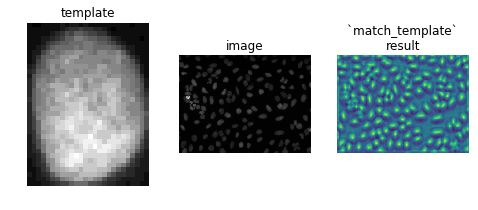

In [63]:
case1_tempmatch = dotempmatch(rgb2gray(case1_im),mypatches[0], show=True)

In [64]:
#adapted from scikit image example... I added the patch calculation/tuning, etc
#CITE: http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html#sphx-glr-auto-examples-segmentation-plot-peak-local-max-py
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

def findpeaks(im, patch, show=False):
    # May want to reevaluate mindist if loner cells tend to be larger than clustered ones
    mindist = int(min(patch.shape)/2) #THIS DENOMINATOR MATTERS FOR TUNING!!!!!!!!!
    # TODO: optimize size?
    image_max = ndi.maximum_filter(im, size=20, mode='constant')

    # Made the min_distance equal to half the size of the minimum dimension on the patch
    # This wasn't working for nuclei at the border until I added the exclude_border flag
    coordinates = peak_local_max(im, min_distance=mindist, exclude_border=0)

    if show:
        fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
        ax = axes.ravel()
        ax[0].imshow(im, cmap=plt.cm.gray)
        ax[0].axis('off')
        ax[0].set_title('`match_template`\nresult')

        ax[1].imshow(image_max, cmap=plt.cm.jet)
        ax[1].axis('off')
        ax[1].set_title('Maximum filter')

        ax[2].imshow(im, cmap=plt.cm.gray)
        ax[2].autoscale(False)
        ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
        ax[2].axis('off')
        ax[2].set_title('Peak local max')

        fig.tight_layout()

        plt.show()
    
    return image_max, coordinates

Future improvement: We can definitely get better performance out of the peak finder, especially around the borders... need to research this. 

Update: there's a border flag that improved performance; adequate for now.

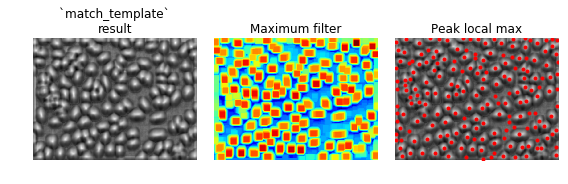

In [65]:
case1_immax, case1_peakcoords = findpeaks(case1_tempmatch, mypatches[0], show=True)

Now we can use the watershed to set the boundaries and the template matching peaks to decide when to combine watershed segments

In [66]:
#Future improvement: this could be way more efficient... brute force for now to get it working
#note: maxim is in here for debugging... remove when pipeline finished
#check this out for efficiency https://math.stackexchange.com/questions/2399957/shortest-distance-between-two-digital-blobs
def calc_nearest(watershed, template_peak_list, maxim, show=False):
    merged_im = np.zeros(watershed.shape)
    for la in np.unique(watershed)[1:]:
        la_bin = (watershed == la)
        la_coords = np.zeros([sum(sum(la_bin)),2])
        la_coords[:,0], la_coords[:,1] = np.where(la_bin)
        norm_matrix = np.zeros([template_peak_list.shape[0]])
        for i in range(template_peak_list.shape[0]):
            normvec = np.linalg.norm(la_coords - template_peak_list[i,:])
            norm_matrix[i] = int(normvec.min())
        minnorm = norm_matrix.min()
        minidx = np.where(norm_matrix == minnorm)[0][0]
        merged_im[la_bin] = minidx
    if show:
        fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
        ax = axes.ravel()
        ax[0].imshow(watershed, cmap=cmap_prism, vmin=0.001)
        ax[0].plot(template_peak_list[:, 1], template_peak_list[:, 0], 'w.')
        ax[0].axis('off')
        ax[0].set_title('watershed')

        ax[1].imshow(maxim, cmap=plt.cm.jet)
        ax[1].axis('off')
        ax[1].set_title('Maximum filter')
        
        ax[2].imshow(merged_im, cmap=cmap_prism, vmin=0.001)
        ax[2].autoscale(False)
        #ax[2].plot(template_peak_list[:, 1], template_peak_list[:, 0], 'b.')
        ax[2].axis('off')
        ax[2].set_title('Merged')
    debug=False
    if debug:
        fig, axes = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=True)
        ax = axes.ravel()
        ax[0].imshow(watershed, cmap=cmap_prism, vmin=0.001)
        ax[0].plot(template_peak_list[minidx, 1], template_peak_list[minidx, 0], 'w.')
        ax[0].axis('off')
        ax[0].set_title('watershed')

        ax[1].imshow(la_bin, cmap=cmap_prism, vmin=0.001)
        ax[1].plot(template_peak_list[minidx, 1], template_peak_list[minidx, 0], 'w.')
        ax[1].axis('off')
        ax[1].set_title('blob')
        
        ax[2].imshow(watershed>0, cmap=plt.cm.gray)
        ax[2].autoscale(False)
        ax[2].plot(template_peak_list[:, 1], template_peak_list[:, 0], 'b.')
        ax[2].plot(template_peak_list[minidx, 1], template_peak_list[minidx, 0], 'y.')
        ax[2].axis('off')
        ax[2].set_title('Peak local max')
        
        ax[3].imshow(merged_im, cmap=cmap_prism, vmin=0.001)
        ax[3].axis('off')
        ax[3].set_title('merged_im')

        
    return merged_im

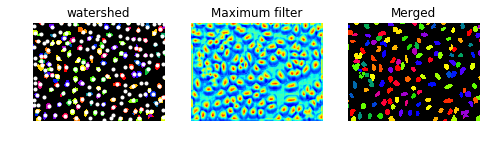

In [67]:
case1_merged_image = calc_nearest(labels, case1_peakcoords,case1_tempmatch, show=True)

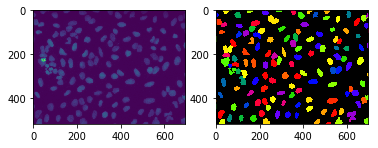

In [68]:
subplot(1,2,1)
imshow(rgb2gray(case1_im))
subplot(1,2,2)
imshow(case1_merged_image, cmap=cmap_prism, vmin=0.01)

This is working pretty well... one set of close maxima were not split until I tuned the mindist parameter in findpeaks. This needs testing to find an adequate calculation that works with a range of cell shapes/sizes.

We have a few problems that might be fixed with a second iteration of watershed, perhaps (enforce the watershed boundary on blobs that have multiple nuclei). Another option is to use more than one filter (ideal nucleus "patch") to select peaks and/or identify areas that need QC.

Now the real test... how does it work on a variety of images?

In [69]:
#Pick the patch that's the median size... hopefully this is "typical"
def pickpatch(mypatches):
    if len(mypatches)>2:
        patchsizes = [sum(sum(i)) for i in mypatches]
        if len(patchsizes)/2 == int(len(patchsizes)/2):
            med = np.median(patchsizes[1:])
        else:
            med = np.median(patchsizes)
        whichpatch = np.where(patchsizes==med)[0][0]
    else:
        whichpatch = 0
    return mypatches[whichpatch]

In [70]:
#Put Part II together into a single function
def segment_nuclei(im, mask, templateN=0, kmfac=2, show=False): #templateN is for debugging (test patches)
    #we need the image for the patches
    im_1ch = reduce_to_one_channel(im)
    imshow(im_1ch)
    #Segmentation
    #note: this will be calculated from im when pipeline done

    #calculate the watershed segmentation on the mask 
    labels = dowatershedseg(mask)

    #calculate the kmeans or dbscan segmentation on the mask
    cluster_im = docluster(mask, alg='dbscan')
    #compare segmentations to identify "ideal" lonely cells
    agreement = compare_segmentations(cluster_im, labels, show=show, title1='dbscan',title2='watershed')
    agreement_labels = labels*agreement
    #extract patches from original image (original intensities) 
    #NOTE: need to extend this to multichannel
    mypatches = make_patches(agreement_labels, im_1ch)
    
    if len(mypatches)<1:
        print("NO PATCHES... TAKING OFF HMIN THRESH")
        #calculate the watershed segmentation on the mask 
        labels = dowatershedseg(mask, hminthresh=0)

        #calculate the kmeans or dbscan segmentation on the mask
        cluster_im = docluster(mask, alg='dbscan')
        #compare segmentations to identify "ideal" lonely cells
        agreement = compare_segmentations(cluster_im, labels, show=show, title1='dbscan',title2='watershed')
        agreement_labels = labels*agreement
        #extract patches from original image (original intensities) 
        #NOTE: need to extend this to multichannel
        mypatches = make_patches(agreement_labels, im_1ch)
    
    rep_patch = pickpatch(mypatches)

    #use patches to identify regions that match the image-specific template cell
    tempmatch = dotempmatch(im_1ch,rep_patch, show=show)
    immax, peakcoords = findpeaks(tempmatch, mypatches[0])
    
    #merge watershed segments based on the template matching
    merged_image = calc_nearest(labels, peakcoords, tempmatch, show=show)
    return merged_image

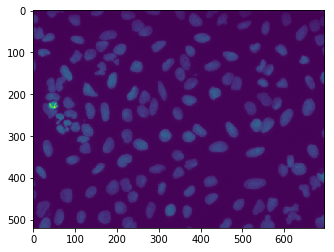

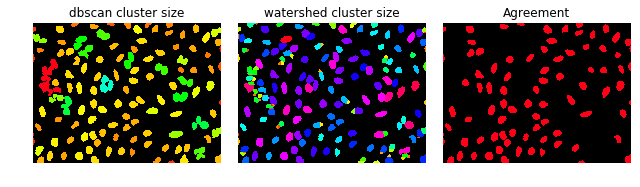

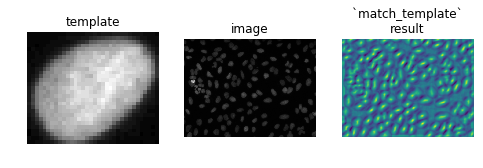

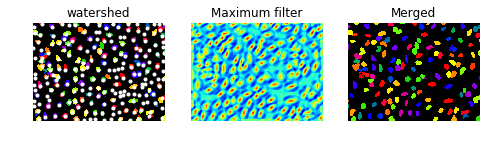

In [71]:
case1_part2 = segment_nuclei(case1_im, case1_mask, show=True)
imshow(case1_part2, cmap=cmap_prism, vmin=0.001)

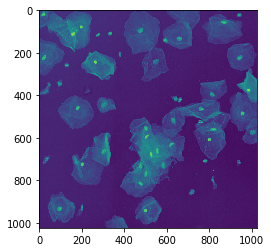

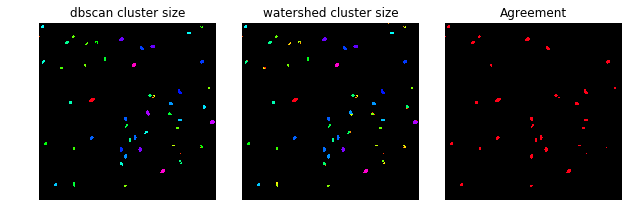

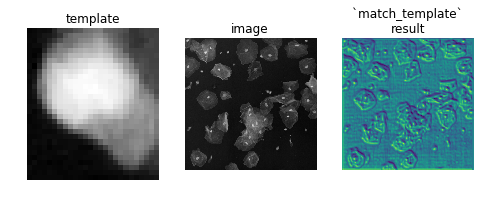

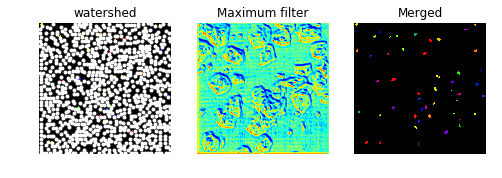

In [72]:
test_part2 = segment_nuclei(test, test_mask, show=True)
imshow(test_part2, cmap=cmap_prism, vmin=0.001)

Template matching is not working on this one (above)... just a simple circular filter... BUT these are far enough away the watershed segmentation doesn't really need the assist from the template matching so I think it's okay

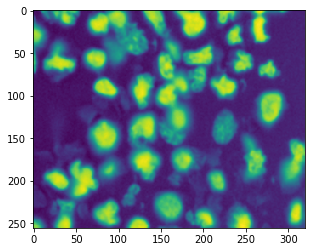

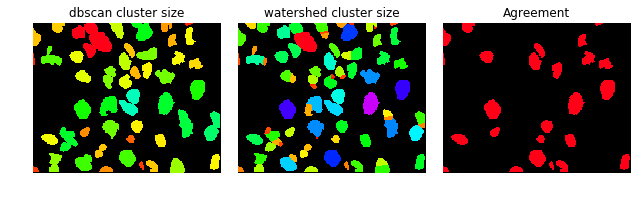

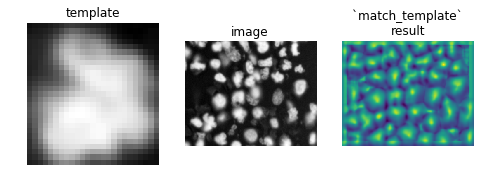

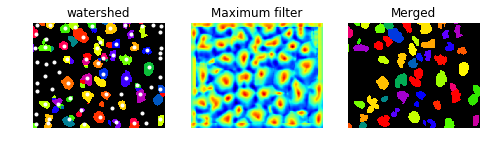

In [73]:
test_part2 = segment_nuclei(test_color, test_color_mask, show=True)
imshow(test_part2, cmap=cmap_prism, vmin=0.001)

In [74]:
def save_part_II(imsets, savedir='test'):
    exception_list = []
    for i,t in enumerate(imsets):
        print(i, t.split('/')[-1])
        #calculate aggregate mask
        maskloc = os.path.join(t,'masks')
        wholemask = aggmasks(maskloc)
        #get image
        impath = glob(t+'/im*/*.png')[0]
        im_preproc = preproc(impath)
        try:
            im_segmented = segment_nuclei(im_preproc, wholemask)
            np.save(os.path.join(savedir,t.split('/')[-1]), im_segmented)
        except:
            exception_list.append(t)
            print('CANNOT SEGMENT IMAGE')
            continue
    return exception_list

#This pipeline was updated to choose the median kernel size out of all the "loner" cells and also to apply thresholding on local minima for the watershed implementation

failed_pype1 = save_part_II(trainsets, 'kaggle_outputs/pype1')

0 5cc036b65f7f2d5480e2be111a561f3713ac021683a9a9138dc49492a29ce856
1 68f833de9f8c631cedd7031b8ed9b908c42cbbc1e14254722728a8b7d596fd4c
2 6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56
3 e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b
4 a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9c4d7b7428cfcb2eda4
5 3441821ebea04face181c9e2f4d0d09727c764827ac51b9e7fbadbebabeab225
6 a0afead3b4fe393f6a6159de040ecb2e66f8a89090abf0d0bf5b8e1d38ae667c
7 98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0
8 d3ce382f190ee24729bd2e80684c11bef72bc9c733cdbbc19a17d2c1b2e775f7
9 c0152b1a260e71f9823d17f4fbb4bf7020d5dce62b4a12b3099c1c8e52a1c43a
10 e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243
11 4ff152d76db095f75c664dd48e41e8c9953fd0e784535883916383165e28a08e
12 fadeb0ab092833f27daaeb3e24223eb090f9536b83f68cde8f49df7c544f711b
13 1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5
14 2d53d7ec0c579fffd6710c956288537d46c719a93c6a04ac0d6550f

120 5afcbfd0dd64392aa1e233b996d0bfb4354ee7119f30ae111c33d0fe4df11590
121 bfe8ef193a68a0a86a5e4ae1ddc27bda3f9ffe170494395be4030ba72737c565
122 442c4eb0185698fe7d148c108a46f74abd399aecda2f4f22981a1671cd95dd7d
123 b1a239838c7dbb34ffea851ad537899f24da62f4e3f3fd6d835ff7b922f27313
124 5b12df18e4ae4df5af06052584cf0e6bef58ee2a220653890636eef88a944e14
125 2a2032c4ed78f3fc64de7e5efd0bec26a81680b07404eaa54a1744b7ab3f8365
126 5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974
127 1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867
128 876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25
129 9a71a416f98971aa14f63ef91242654cc9191a1414ce8bbd38066fe94559aa4f
130 317832f90f02c5e916b2ac0f3bcb8da9928d8e400b747b2c68e544e56adacf6b
131 10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28
132 bbfc4aab5645637680fa0ef00925eea733b93099f1944c0aea09b78af1d4eef2
133 79dfcbc9361edd3a1ffe81a5bdaa22a197ad1341f3fa64b86a646c2607d6b324
134 1c2f9e121fc207efff79d46390df1a

237 6fb82031f7fc5f4fa6e0bc2ef3421db19036b5c2cdd2725009ab465d66d61d72
238 d1b173875e2261f55014bd27bd7174b9ae1c769338c1b31b5d737e9e60175993
239 8175a55b711c948fe383bd3b91b6ca1b9e048a5241e0be13aff31ce2674fbe6d
240 da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e75190d6ba3588f69058c8
241 0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275
242 ff3407842ada5bc18be79ae453e5bdaa1b68afc842fc22fa618ac6e6599d0bb3
243 4d40de30a3db3bc4f241cb7f48e8497c11e8f20a99bf55788bdce17242029745
244 8d29c5a03e0560c8f9338e8eb7bccf47930149c8173f9ba4b9279fb87d86cf6d
245 fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de
246 abbfff07379bceb69dba41dad8b0db5eb80cc8baf3d4af87b7ee20b0dac32215
247 fc9269fb2e651cd4a32b65ae164f79b0a2ea823e0a83508c85d7985a6bed43cf
248 f534b43bf37ff946a310a0f08315d76c3fb3394681cf523acef7c0682240072a
249 f6b16c885c0b2bc0d0eb2bb2eeb0a2753ebafb5a7a91da10e89b0b0478984637
250 7f4d7b549d0f1a110191e2aded872943d85892bc30667f19fe9de97a5370b08e
251 6bc8cda54f5b66a2a27d962ac219f8

353 be771d6831e3f8f1af4696bc08a582f163735db5baf9906e4729acc6a05e1187
354 a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c
355 cdab367b30db47061df837c1ae9fa875d6057614f797332d37d3513517d6c694
356 1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5
357 40946065f7e4b6038599fbfd419f2a67e7635b6f89db3ed6c0d67c8801521af1
358 4327d27591871e9c8d317071a390d1b3dcedad05a9746175b005c41ea0d797b2
359 eb96fc6cbf6880bf05c4309857ae33844a4bc2152e228eff31024e5265cf9fc3
360 4b274461c6d001a7a9aeaf5952b40ac4934d1be96b9c176edfd628a8f77e6df2
361 4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0
362 60cb718759bff13f81c4055a7679e81326f78b6a193a2d856546097c949b20ff
363 7d40ea6ead1bec903f26d9046d291aedcb12a584b4d3b337ea252b34c7d86072
364 9f073db4acd7e634fd578af50d4e77218742f63a4d423a99808d6fd7cb0d3cdb
365 e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2
366 44ab6a09eedee848b072ea3acd0f4e781f9c43b8d4e3d62598e1024584bf0b01
367 cf26c41245febfe67c2a1682cc4ee8

469 0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c
470 61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e
471 4e23ecf65040f86420e0201134e538951acdeda84fbb274311f995682044dd64
472 0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426
473 b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac
474 00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552
475 55ff2b0ec48b76e10c7ee18add5794005cd551697f96af865c763d50da78dd9c
476 9facc652efe19f634639585d692a53dd6c2a8e2f0c9baebdfd85b9b41ec58851
477 35ca5f142a7d7a3e4b59f1a767a31f87cb00d66348226bc64094ee3d1e46531c
478 b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845bdc01b2b3ee2299229
479 f9ea1a1159c33f39bbe5f18bb278d961188b40508277eab7c0b4b91219b37b5d
480 b1eb0123fe2d8c825694b193efb7b923d95effac9558ee4eaf3116374c2c94fe
481 6aa7dd0c88bec4f96cdd497f9c37779733033d9ec6513307461302d36bd32ac7
482 af576e8ec3a8d0b57eb6a311299e9e4fd2047970d3dd9d6f52e54ea6a91109da
NO PATCHES... TAKING OFF HMIN THRE

586 f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886
587 2349e95ece2857c89db7e4a8be8c88af0b45f3c4262608120cb3bd6ef51fd241
588 1815cf307859b3e13669041d181aa3b3dbbac1a95aef4c42164b223110c09168
589 431b9b0c520a28375b5a0c18d0a5039dd62cbca7c4a0bcc25af3b763d4a81bec
590 f9ac03b0344ce8c48bc058448541f9211a1e5f4c94fdaf633dd534328d8610ab
591 f35ab34528e3e2d2589d24cbffc0e10024dfc474a68585d0b5feb7b05aa0067f
592 9cdac2870cfe65b6cb61bd151020068a3b427118a27343767b07ea39483fee32
593 3934a094e8537841e973342c7f8880606f7a2712b14930340d6f6c2afe178c25
594 fa73f24532b3667718ede7ac5c2e24ad7d3cae17b0a42ed17bbb81b15c28f4ae
595 5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8
596 f01a9742c43a69f087700a43893f713878e537bae8e44f76b957f09519601ad6
597 c35e6e3ea39a718e1b7aff66e4cc678efd662f9b5336b74d69c1d6bca7aaf288
598 30f65741053db713b3f328d31d3234b6fedbe31df65c1a8ea29be28146cab789
599 34c9f4eb2af8b8f46b1d88b74bde16f4614cd08948c2f1d817eb629afc512e7a
600 cfabf7379c5591d40aa4a20c86b419

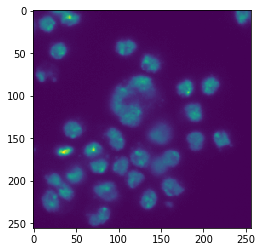

In [75]:
failed_pype2 = save_part_II(trainsets, 'kaggle_outputs/pype2')

In [76]:
len(failed_pype2)

17

# STEP III: EVALUATION

In [77]:
from scipy.stats import mode

In [78]:
def test_part2(imsets, saved_dir):
    ncorrect_list = np.zeros(len(imsets))
    gold_N_nuclei = np.zeros(len(imsets))
    my_N_nuclei = np.zeros(len(imsets))
    pcva_list = []
    bad_list = []
    exception_list = []
    for i,t in enumerate(imsets):
        #print(i, t)
        #calculate aggregate mask
        try:
            im_segmented = np.load(os.path.join(saved_dir,t.split('/')[-1]+'.npy'))
        except:
            print("Exception loading..."+str(i))
            exception_list.append(t)
            continue
        
        #get gold standard mask list that separates nuclei
        masklist = glob(os.path.join(t,'masks/*.png'))
        gold_N_nuclei[i] = len(masklist)
        my_N_nuclei[i] = len(np.unique(im_segmented))
        pcva_mask_vals = np.zeros(len(masklist))
        for j,m in enumerate(masklist):
            maskim = imread(m)
            maskedseg = maskim*im_segmented
            modeval, modecount = mode(np.ndarray.flatten(maskedseg[maskedseg>0]))
            if modeval.shape[0]==1:
                pcva_mask_vals[j] = calc_pcva(im_segmented==int(modeval[0]), maskim>0)
            elif modeval.shape[0]<1:
                pcva_mask_vals[j] = 0
        pcva_list.append(pcva_mask_vals)
        ncorrect_list[i] = sum(pcva_mask_vals==100)
        if pcva_mask_vals.mean()<50:
            bad_list.append(t)
    return pcva_list, gold_N_nuclei, my_N_nuclei, bad_list, exception_list
        
        

In [79]:
pcva_list2, gold_N_nuclei2, my_N_nuclei2, bad_list2, exception_list2 = test_part2(trainsets, 'kaggle_outputs/pype2/')

Exception loading...50
Exception loading...141
Exception loading...152
Exception loading...198
Exception loading...287
Exception loading...302
Exception loading...310
Exception loading...320
Exception loading...370
Exception loading...396
Exception loading...415
Exception loading...440
Exception loading...461
Exception loading...482
Exception loading...497
Exception loading...503


In [80]:
def savepkl(data, path):
    pickle.dump(data, open(path, "wb" ))

def loadpkl(path):
    return pickle.load(open(path, "rb" ))

In [81]:
def testim(basepath):
    im = preproc(glob(basepath+'/im*/*.png')[0])
    maskpath = glob(basepath+'/ma*')[0]
    segim = segment_nuclei(im, aggmasks(maskpath), show=True)

In [82]:
import pandas as pd

Text(0.5,1,'Histogram of difference between pipeline and gold standard \n nucleus counts per slide')

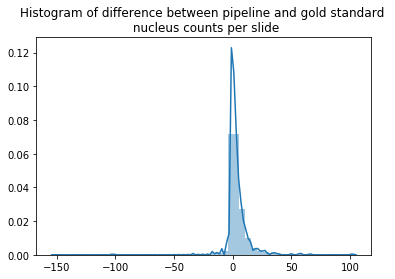

In [83]:
sns.distplot(gold_N_nuclei2-my_N_nuclei2)
plt.title('Histogram of difference between pipeline and gold standard \n nucleus counts per slide')

Text(0.5,1,'Average Percent Overlap (per slide) between \n individual nucleus masks and pipeline segmentation')

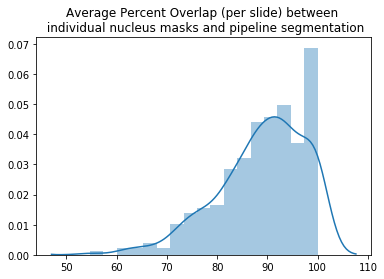

In [84]:
avg_pcva = np.zeros(len(pcva_list2))
for i,p in enumerate(pcva_list2):
    avg_pcva[i] = p.mean()
sns.distplot(avg_pcva)
plt.title('Average Percent Overlap (per slide) between \n individual nucleus masks and pipeline segmentation')

# PART IV: ANALYZE FAILURES

In [85]:
len(bad_list2) #no cases had PCVA/percent overlap/sorensen-dice less than 50! Improvement over pipeline 1

0

In [86]:
len(exception_list2) #18 cases couldn't be processed by the pipeline

16

In [87]:
for ex in exception_list2:
    Image(glob(os.path.join(ex, 'im*/*.png'))[0])

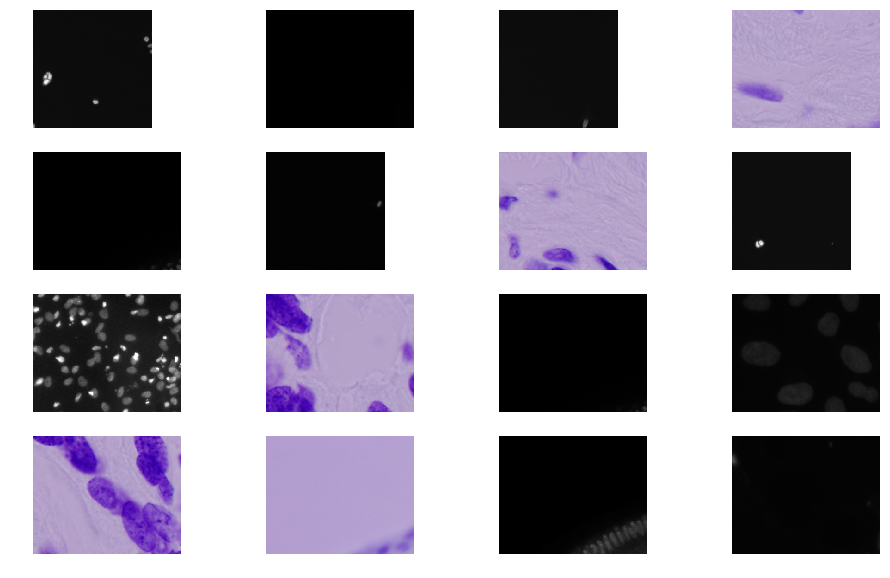

In [92]:
fig, axes = plt.subplots(4,4, sharex=True, sharey=True)
ax = axes.ravel()
for i,ex in enumerate(exception_list2):
    expath = glob(os.path.join(ex, 'im*/*.png'))[0]
    ax[i].imshow(imread(expath))
    ax[i].axis('off')
fig.set_size_inches(w=16,h=10)

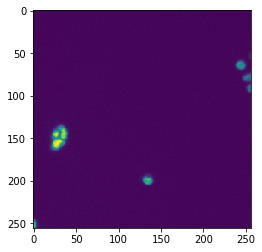

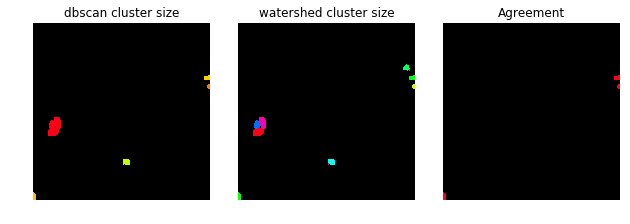

NO PATCHES... TAKING OFF HMIN THRESH


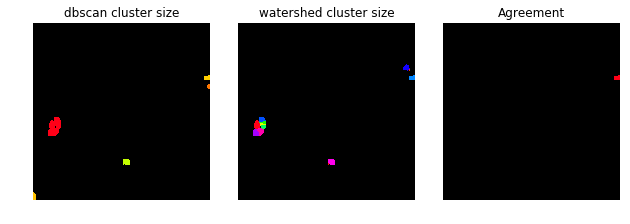

IndexError: list index out of range

In [93]:
#this failed because it couldn't isolate a single "good" nucleus that wasn't against the wall. 
#Probably good to pull out during QC anyway.
testim(exception_list2[0])

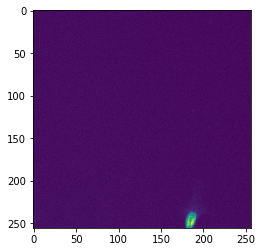

ValueError: minvalue must be less than or equal to maxvalue

<Figure size 648x216 with 3 Axes>

NO PATCHES... TAKING OFF HMIN THRESH


ValueError: minvalue must be less than or equal to maxvalue

<Figure size 648x216 with 3 Axes>

IndexError: list index out of range

In [94]:
#Several of this type of image failed... need to design solution and dig into why it's failing
#also these are very large images so they might have been killed when I had to interrupt kernel
testim(exception_list2[2])

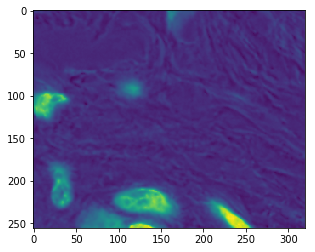

ValueError: minvalue must be less than or equal to maxvalue

<Figure size 648x216 with 3 Axes>

NO PATCHES... TAKING OFF HMIN THRESH


ValueError: minvalue must be less than or equal to maxvalue

<Figure size 648x216 with 3 Axes>

IndexError: list index out of range

In [95]:
#Couldn't extract patches; probably good to pull out for QC
testim(exception_list2[6])

Running a gaussian filter over this prior to processing might help this... some templates are a bit heterogeneous

# TODO

- Tuning: need to run a cross-validation to tune the following parameters
    - suppress local minima parameter with h-minima xfm (not implemented in skimage)
    - make watershed more granular... we want to air on the side of oversegmentation so that we don't miss components... the filtering/dbscan should be enough to merge peaks if needed
    